In [1]:
import nbimporter # to import methods from another notebook
import manta_file_processing as mfp
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import time
import random
import os

Importing Jupyter notebook from manta_file_processing.ipynb


In [2]:
heatmap_order=("left-eye","right-eye","left-gill","right-gill","tail")

In [3]:
from importlib import reload
reload(mfp)

Importing Jupyter notebook from manta_file_processing.ipynb


<module 'manta_file_processing' from 'manta_file_processing.ipynb'>

In [4]:
if os.name=="nt":
    folder="C:\\YandexDisk\\_QUT\\Project_1\\MAntas_imag\\0_manta_selected_annotated_some"
else:
    folder="/tf/notebooks/data/0_manta_selected_annotated_some"
dataset=mfp.get_manta_files(folder=folder)

total:1801
labelled:295


In [5]:
df=dataset[dataset.body_landmark_path.isnull()==False].sample(frac=1)
manta_data=np.array(df[["image_path","body_landmark_path"]])
#data=np.array([df.image_path,df.body_landmark_path])
manta_data.shape

(295, 2)

In [6]:
image_size=[100,100]
heatmap_size=[17,17]

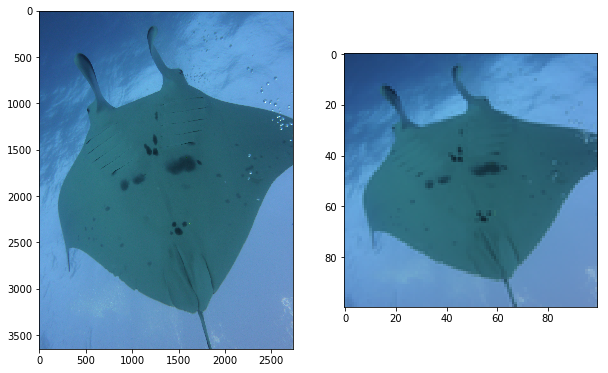

In [7]:
im_path,blm_path = manta_data[3]
image = Image.open(im_path)
body_landmarks=mfp.extract_body_landmarks(blm_path)


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 10))
axes[0].imshow(image)

image=mfp.denormalize(mfp.image_to_numpy(image,image_size))
axes[1].imshow(image)    
#axes[2].imshow(image[:,::-1])   
plt.show()


In [8]:
X=[]
y=[]
i=0
print ("total:" + str(manta_data.shape[0]))

for im_path,blm_path in manta_data:#[:20]:
    try:
        image = Image.open(im_path)
        body_landmarks=mfp.extract_body_landmarks(blm_path)
    except:
        print(" \n Error on "+blm_path)
        
    image=mfp.image_to_numpy(image,image_size)
    numpy_heatmaps=mfp.gen_heatmaps(body_landmarks,heatmap_size=heatmap_size)
    #numpy_heatmaps=mfp.heatmaps_to_numpy(heatmaps)
    
    if image.shape[2]>3:
        print("\n More then 3 channels")
        print(blm_path)
        numpy_heatmaps=None
    
    if numpy_heatmaps is not None and numpy_heatmaps.sum()>0:
        y.append(numpy_heatmaps[:,:,4:])
        X.append(image) 
    print(i,end=" ")
    i+=1

X=np.array(X)
y=np.array(y)
print("\n====================")
print("Done.\nX.shape="+str(X.shape))
print("y.shape="+str(y.shape))


total:295
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 More then 3 channels
C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0003 Isabella\3-F-20160609-AM-LEI-CameraTrap-ISABELLA-1.json
15 16 17 18 19 20 21 22 23  
 Error on C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0012 Laverna\12-F-20130627-LEI-MichelleOoi-LAVERNA-2.json
24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 
 More then 3 channels
C:\YandexDisk\_QUT\Project_1\MAntas_imag\0_manta_selected_annotated_some\0002 Theola\2-F-20160709-LEI-GavinHodson-THEOLA.json
58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 
 More 

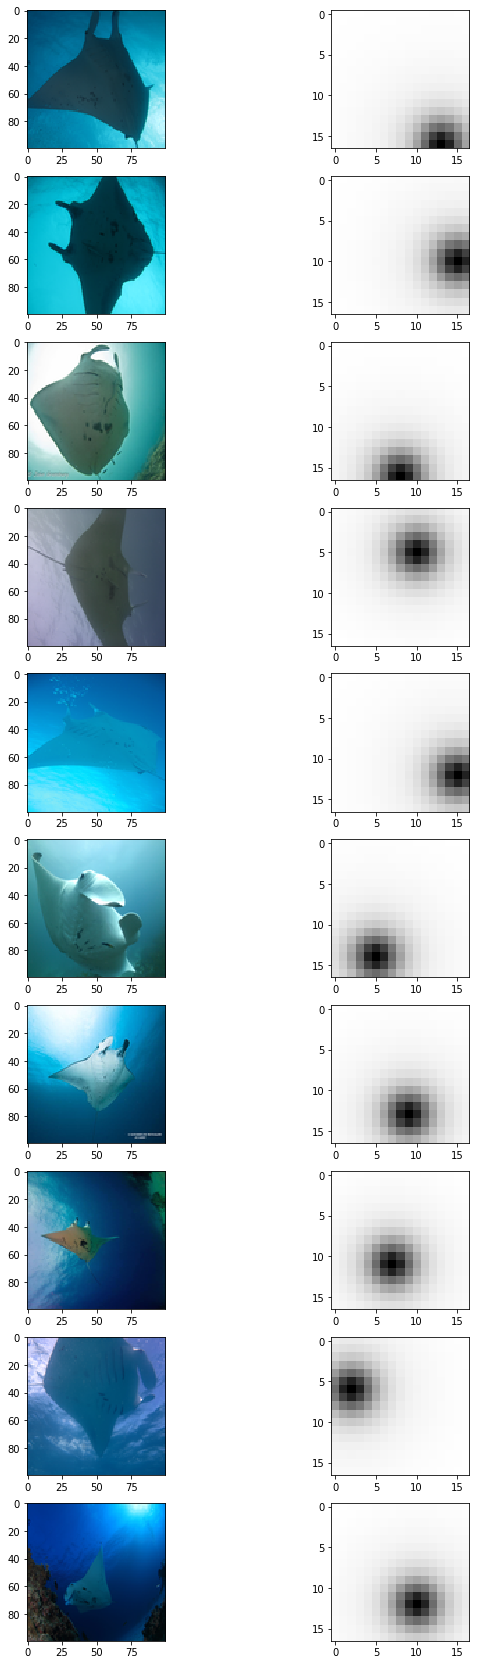

In [9]:

n=10
samples=random.sample(list(np.arange(X.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=2,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X[s]))
    axes[i,1].imshow(y[s][:,:,0],cmap='Greys')
plt.show()


In [10]:
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense,Conv2DTranspose
from tensorflow.python.keras.layers import BatchNormalization,AveragePooling2D,Activation

from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import Adam

In [11]:
import copy
input_shape=copy.copy(image_size)
input_shape.append(3)
batch_size=8
nb_train_samples=int(round(X.shape[0]*0.95,0))
X_train=X[:nb_train_samples]
X_test =X[nb_train_samples:]
y_train=y[:nb_train_samples]
y_test =y[nb_train_samples:]

In [12]:
#pip install h5py
#pip install cython
#restart jupyther
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=input_shape)
vgg16_net.trainable = False
vgg16_net.summary()

#from tensorflow.keras.models import Model
#mymodel = Model(vgg16_net.get_input_at(0), vgg16_net.layers[n_layer].get_output_at(0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [13]:
model=Sequential()
model.add(vgg16_net)

model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=64,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Conv2DTranspose(filters=1,
                         kernel_size=3,
                         strides=1, 
                         activation='relu'))
model.add(BatchNormalization())

model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 512)         2048      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 17, 17, 1)         289       
__________

In [14]:
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['binary_accuracy'])

Train on 248 samples, validate on 28 samples
Epoch 1/100
248/248 [==============================] - 20s 79ms/step - loss: 0.7682 - binary_accuracy: 0.0554 - val_loss: 1.0461 - val_binary_accuracy: 0.0811
Epoch 2/100
248/248 [==============================] - 5s 22ms/step - loss: 0.7241 - binary_accuracy: 0.0653 - val_loss: 0.8524 - val_binary_accuracy: 0.1487
Epoch 3/100
248/248 [==============================] - 5s 22ms/step - loss: 0.7048 - binary_accuracy: 0.0673 - val_loss: 0.7415 - val_binary_accuracy: 0.1693
Epoch 4/100
248/248 [==============================] - 5s 22ms/step - loss: 0.6915 - binary_accuracy: 0.0676 - val_loss: 0.6797 - val_binary_accuracy: 0.1749
Epoch 5/100
248/248 [==============================] - 5s 22ms/step - loss: 0.6812 - binary_accuracy: 0.0666 - val_loss: 0.6513 - val_binary_accuracy: 0.1766
Epoch 6/100
248/248 [==============================] - 5s 22ms/step - loss: 0.6746 - binary_accuracy: 0.0687 - val_loss: 0.6422 - val_binary_accuracy: 0.1772
Epoch 

248/248 [==============================] - 5s 22ms/step - loss: 0.5373 - binary_accuracy: 0.0725 - val_loss: 0.5121 - val_binary_accuracy: 0.1756
Epoch 53/100
248/248 [==============================] - 5s 22ms/step - loss: 0.5302 - binary_accuracy: 0.0725 - val_loss: 0.5100 - val_binary_accuracy: 0.1765
Epoch 54/100
248/248 [==============================] - 5s 22ms/step - loss: 0.5281 - binary_accuracy: 0.0725 - val_loss: 0.5074 - val_binary_accuracy: 0.1767
Epoch 55/100
248/248 [==============================] - 5s 22ms/step - loss: 0.5260 - binary_accuracy: 0.0725 - val_loss: 0.5078 - val_binary_accuracy: 0.1768
Epoch 56/100
248/248 [==============================] - 5s 22ms/step - loss: 0.5234 - binary_accuracy: 0.0725 - val_loss: 0.5045 - val_binary_accuracy: 0.1762
Epoch 57/100
248/248 [==============================] - 5s 22ms/step - loss: 0.5256 - binary_accuracy: 0.0725 - val_loss: 0.5021 - val_binary_accuracy: 0.1768
Epoch 58/100
248/248 [==============================] - 5s 

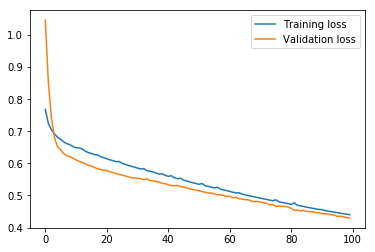

In [15]:
start_time = time.time()

history=model.fit(X_train,y_train,batch_size=32,epochs=100,validation_split=0.1)

print("\nTraining time in seconds:'--- %s seconds ---" % (time.time() - start_time))

loss = history.history['loss']
val_loss= history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.show()

In [16]:
pred=model.predict(X_test)
X_test.shape

(15, 100, 100, 3)

In [17]:
pred.shape

(15, 17, 17, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


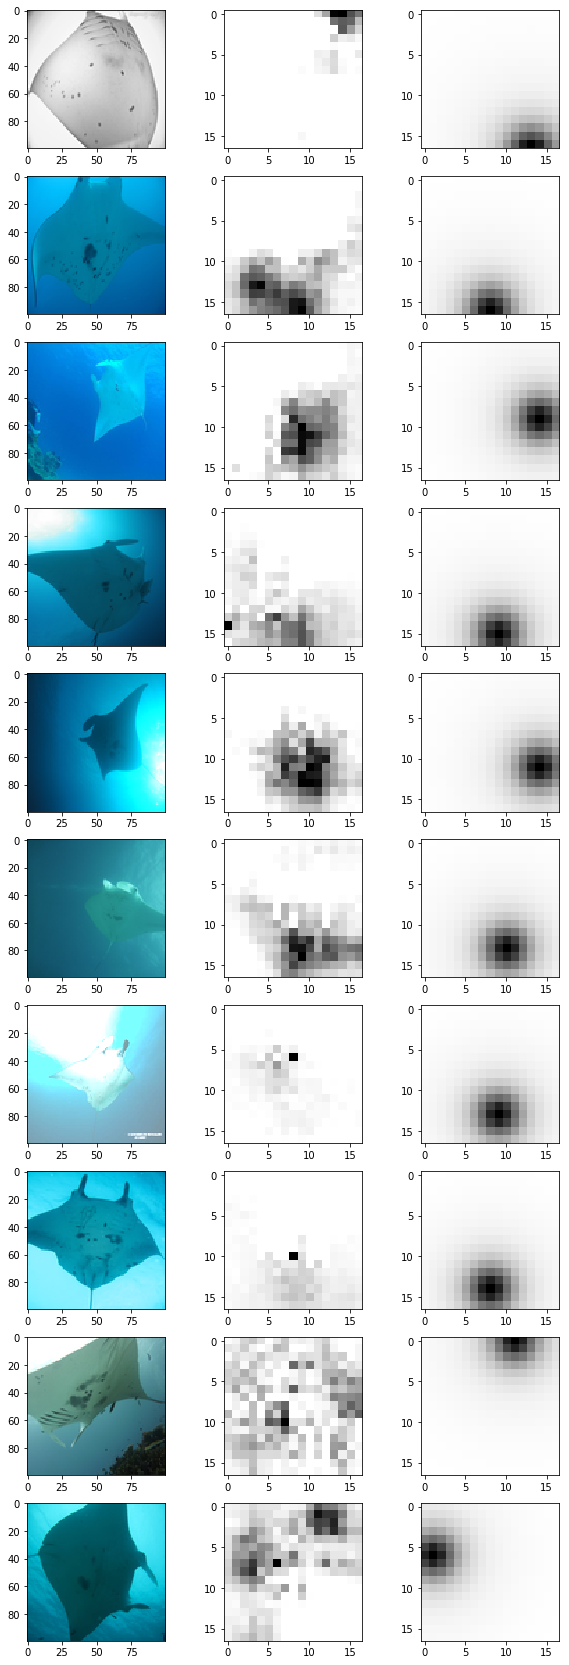

In [18]:
n=10#X_test.shape[0]
samples=random.sample(list(np.arange(pred.shape[0])),n)
fig, axes = plt.subplots(nrows=n, ncols=3,figsize=(10, 30))
for i,s in zip(range(len(samples)),samples):
    axes[i,0].imshow(mfp.denormalize(X_test[s]))
    axes[i,1].imshow(pred[s][:,:,0],cmap='Greys')
    axes[i,2].imshow(y_test[s][:,:,0],cmap='Greys')
plt.show()

In [19]:
# large heatmap
# Распределение Коши  1/(1+((x-xo)/r)**2)
+ validation set
+ get rid of maxPooling layer?
+ augmentation
+ labelling


SyntaxError: invalid syntax (<ipython-input-19-e48b9a99abf9>, line 3)